# Verify Hashing Methods are Correctly Estimating Associated Distance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.weightstats import ttest_ind
import scipy

from collections import defaultdict
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed
import pandas as pd

## Distance Functions

In [3]:
"""
Jaccard Distance from two kmer sets represented as numpy arrays
"""
def jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return sum(np.logical_and(set_a, set_b)) / sum(np.logical_or(set_a, set_b))

"""
Jaccard Distance from two signature vectors represented as numpy arrays
"""
def approx_jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return sum(set_a == set_b) / set_a.shape[0]

"""
Euclidean Distance from two kmer sets represented as numpy arrays
"""
def euclidean_distance(set_a: np.ndarray, set_b: np.ndarray):
    return np.linalg.norm(set_a - set_b)

"""
Euclidean Distance from two signature vectors represented as numpy arrays

Impossible to calculate directly. Instead we'll just develop an ordering and see if they are associated
"""
def approx_euclidean_distance(set_a: np.ndarray, set_b: np.ndarray):
    return 1 - sum(set_a == set_b) / len(set_a)

"""
Cosine Distance from two kmer sets represented as numpy arrays
"""
def cosine_distance(set_a: np.ndarray, set_b: np.ndarray):
    cos_theta = np.dot(set_a, set_b) / (np.linalg.norm(set_a) * np.linalg.norm(set_b))
    floating_point_correction = min(cos_theta, 1)
    return np.arccos(floating_point_correction)
"""
Cosine Distance from two signature vectors represented as numpy arrays
    Return proportion of hashes where vectors appear on same side * max cosine distance.
"""
def approx_cosine_distance(set_a: np.ndarray, set_b: np.ndarray):
    return (1 - sum(set_a == set_b) / len(set_a)) * np.pi


In [4]:
"""
Returns a ndarray. 
obj[0,:] is first count
"""
def build_kmer_count_matrix(fastqFile):
    """
    Return the characteristic vector for a single read, i
    """
    def get_characteristic_vector(i, fastqFile, kmer_dict, minKmerRead = 400):
        characteristicVector = np.zeros(minKmerRead, dtype=np.int16)
        kmerDir = f"../../../output/kmerTables_200bp/20mers"
        chrom = os.path.basename(fastqFile).split("_")[0]
        regionDir = os.path.join(kmerDir, chrom, os.path.basename(fastqFile)[:-6])
        tableFile = os.path.join(regionDir, f"read{i+1}.ktab") # Files are 1-indexed

        # Some regions are too small, don't have haplotypes, or too few reads and led to errors. So table doesn't exist
        if not os.path.isfile(tableFile):
            raise FileNotFoundError(tableFile)

        command = ["Tabex", tableFile, "LIST"]
        table_output = str(subprocess.check_output(command))

        for row in  table_output.split("\\n")[1:-1]: # First and last line don't contain kmers
            kmer, count = row.strip().split("=")
            kmer = kmer.split(":")[1].strip().upper()
            count = int(count.strip())

            # Get kmer index
            if kmer not in kmer_dict.keys():
                kmer_dict[kmer] = len(kmer_dict)

            localIndex = kmer_dict[kmer]
            if localIndex >= minKmerRead:
                characteristicVector = np.concatenate((characteristicVector, np.zeros(minKmerRead)), axis=0)
                minKmerRead *= 2
            characteristicVector[localIndex] = count

        return characteristicVector, kmer_dict

    vectors = []
    kmer_dict = dict()
    max_len = -1
    for i in range(100):
        try:
            char_vector, kmer_dict = get_characteristic_vector(i, fastqFile, kmer_dict, minKmerRead = max(400, len(kmer_dict)))
            if char_vector.shape[0] > max_len:
                max_len = char_vector.shape[0]
            vectors.append(char_vector)
        except:
            break
    extended_vectors = []
    for vector in vectors:
        dim_dif = max_len - vector.shape[0]
        if dim_dif == 0:
            extended_vectors.append(vector)
        else:
            temp = np.pad(vector, (0, dim_dif), mode='constant')
            extended_vectors.append(temp)
    return np.stack(extended_vectors, axis = 1)

"""
Returns signature matrix loaded from memory
"""
def build_signature_matrix(fastqFile, matrix_dir):
    signature_matrix_dir = os.path.join(matrix_dir, os.path.basename(fastqFile)[:-6]+".npy")
    return np.load(signature_matrix_dir)


"""
Return two vectors:
    distance_matrix : real distances
    approx_dist_mat : approx distances using signature matrix
"""
def get_dist_vectors(kmer_count_matrix: np.ndarray, signature_matrix: np.ndarray, exact_function, approx_function):
    n = kmer_count_matrix.shape[1]
    vector_len = np.sum(range(n))
    distance_vector = np.zeros((vector_len))
    approx_distance_vector = np.zeros((vector_len))
    index = 0
    for i in range(0, n-1):
        for j in range(i+1, n):
            exact_dist = exact_function(kmer_count_matrix[:,i], kmer_count_matrix[:,j])
            approx_dist = approx_function(signature_matrix[:,i], signature_matrix[:,j])
            distance_vector[index] = exact_dist
            approx_distance_vector[index] = approx_dist

            index += 1
    return distance_vector, approx_distance_vector

"""
Test multiple regions and determine whether hash approximates real distance

B = sample size
"""
def test_many_fastqs(fastq_dir, matrix_dir, filter_type, B = 100):
    if filter_type == "jaccard":
        distance_func = jaccard_distance
        approx_distance_func = approx_jaccard_distance
    elif filter_type == "euclidean":
        distance_func = euclidean_distance
        approx_distance_func = approx_euclidean_distance
    elif filter_type == "cosine":
        distance_func = cosine_distance
        approx_distance_func = approx_cosine_distance
    else:
        raise Exception("Invalid filter type parameter, not in (jaccard, euclidean, cosine)")

    p_vals = []
    output_distance_vector = []
    output_approx_distance_vector = []
    fastqs = os.listdir(fastq_dir)
    fastqs = np.random.choice(fastqs, B, replace = False)
    for fastq_file_base in fastqs:
        fastq_file = os.path.join(fastq_dir, fastq_file_base)
        try:
            kmer_count_matrix = build_kmer_count_matrix(fastq_file)
            signature_matrix = build_signature_matrix(fastq_file, matrix_dir)
        except:
            with open("../tmp/bad_regions", "a") as f:
                f.write(fastq_file+"\n")
            continue
        try:
            distance_vector, approx_distance_vector = get_dist_vectors(kmer_count_matrix, signature_matrix, distance_func, approx_distance_func)
        except:
            print(fastq_file, matrix_dir)
            continue
        results = ttest_ind(distance_vector, approx_distance_vector)
        output_distance_vector = np.concatenate((output_distance_vector, distance_vector), axis = None)
        output_approx_distance_vector = np.concatenate((output_approx_distance_vector, approx_distance_vector), axis = None)
        p_vals.append(results[1])
    return p_vals, fastqs, output_distance_vector, output_approx_distance_vector,

In [5]:
def plot_distances(distance_vector, approx_distance_vector, title:str):
    plt.scatter(approx_distance_vector, distance_vector)
    plt.title(f"Exact vs Approximate: {title.title()} Distance")
    plt.xlabel("Approximate Distance")
    plt.ylabel("Exact Distance")
    plt.show()

    print("Real:")
    print("min\t:", np.min(distance_vector))
    print("mean\t:",np.mean(distance_vector))
    print("max\t:",np.max(distance_vector))
    print("var\t:",np.var(distance_vector))
    print()
    print("Approx:")
    print("min\t:", np.min(approx_distance_vector))
    print("mean\t:",np.mean(approx_distance_vector))
    print("max\t:",np.max(approx_distance_vector))
    print("var\t:",np.var(approx_distance_vector))

## minHash and Jaccard Distance

In [6]:
jaccard = "jaccard"
fastq_dir = "../../../output/HG002_200bp/chr22"
signature_matrix_dir = "../../../output/signatureMtxs_20bp/minHash/1000,21,1"

In [7]:
p_vals, fastqs, jaccard_distance_vector, approx_jaccard_distance_vector = test_many_fastqs(fastq_dir, signature_matrix_dir, jaccard, B=200)

../../../output/HG002_200bp/chr22/chr22_49670291-49671001.fastq ../../../output/signatureMtxs_20bp/minHash/1000,21,1


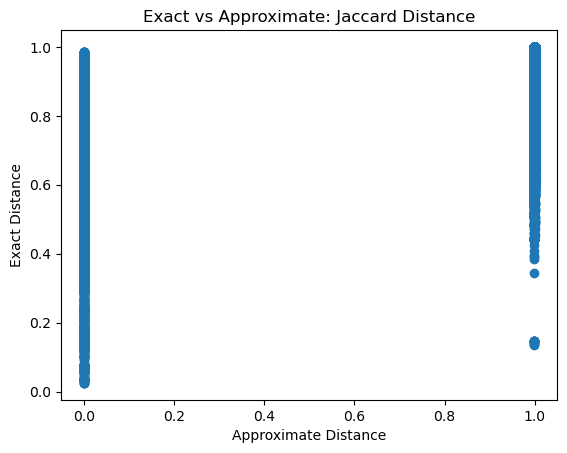

Real:
min	: 0.025024374390640234
mean	: 0.750296345086591
max	: 1.0
var	: 0.030409697446401946

Approx:
min	: 0.0
mean	: 0.3900839666201573
max	: 1.0
var	: 0.2375049407113121

p_val	: 0.0
z_score	 115.27329919842218


In [8]:
plot_distances(jaccard_distance_vector, approx_jaccard_distance_vector, jaccard)
z_score, p_value, dof = ttest_ind(jaccard_distance_vector, approx_jaccard_distance_vector)
print("\np_val\t:", p_value)
print("z_score\t", z_score)

Why is our distribution of approximate distances basically only 0 or 1. This should not be the case.

We can see from the plot that we are on average a little bit lower than 0 on average. This is confirmed in the statistical test showing that we are very confident that the approx_jaccard_distance is not the same distribution as the jaccard_distance distribution. 

Despite this, the relative value is very small and the confidence comes from a very large sample size i.e. a small variance. Then although this estimator is biased, it is only by a small amount.

In [58]:
adj_p_vals = multipletests(p_vals, alpha=0.05, method='fdr_by', maxiter=1, is_sorted=False, returnsorted=False)

## Euclidean Distance and Projection Estimation

In [9]:
fastq_dir = "../../../output/HG002_20bp/chr22"
signature_matrix_dirs = []
for i in range(1,2):
    signature_matrix_dirs.append(f"../../../output/signatureMtxs_20bp/euclidean/1000,21,{i},1")

In [10]:
euclidean_test_outputs = []
for signature_matrix_dir in signature_matrix_dirs:
    euclidean_test_outputs.append(test_many_fastqs(fastq_dir, signature_matrix_dir, "euclidean", B=200))

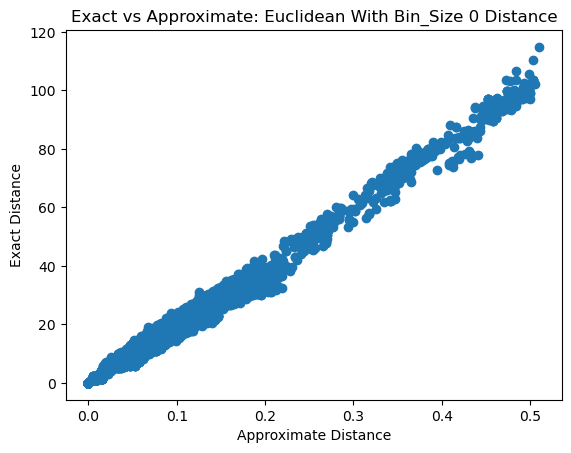

Real:
min	: 0.0
mean	: 17.611891163782076
max	: 114.85643212288984
var	: 235.19015170983926

Approx:
min	: 0.0
mean	: 0.09063209289453635
max	: 0.5104895104895104
var	: 0.005876720780342919

p_val	: 0.0
z_score	: 124.8030329231394


In [11]:
def plot_euclidean(i, output):
    p_vals, fastqs, euclidean_distance_vector, approx_euclidean_distance_vector = output
    plot_distances(euclidean_distance_vector, approx_euclidean_distance_vector, f"Euclidean with bin_size {i}")
    z_score, p_value, dof = ttest_ind(euclidean_distance_vector, approx_euclidean_distance_vector)
    print("\np_val\t:", p_value)
    print("z_score\t:", z_score)

for i, output in enumerate(euclidean_test_outputs):
    plot_euclidean(i, output)

In [ ]:
def fastq_to_signature(fastq_file, signature_dir = "../../../output/signatureMtxs_20bp/euclidean_signature/1000,21,1,1"):
    signature_file = os.path.join(signature_dir, fastq_file).replace("fastq", "npy")
    return np.load(signature_file)

for fastq in euclidean_test_outputs[-1][1]:
    signature_matrix= fastq_to_signature(fastq)
    break

## Cosine Distance and Sketching

In [12]:
fastq_dir = "../../../output/HG002_200bp/chr22"
signature_matrix_dir = "../../../output/signatureMtxs_20bp/sketch/1000,21,1"

In [13]:
p_vals, fastqs, cosine_distance_vector, approx_cosine_distance_vector = test_many_fastqs(fastq_dir, signature_matrix_dir, "cosine", B=200)

/home/wford/miniconda3/envs/workspace/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:994: RuntimeWarning: invalid value encountered in scalar divide
  (d1.sumsquares + d2.sumsquares)
/home/wford/miniconda3/envs/workspace/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:994: RuntimeWarning: invalid value encountered in scalar divide
  (d1.sumsquares + d2.sumsquares)


../../../output/HG002_200bp/chr22/chr22_49670291-49671001.fastq ../../../output/signatureMtxs_20bp/sketch/1000,21,1


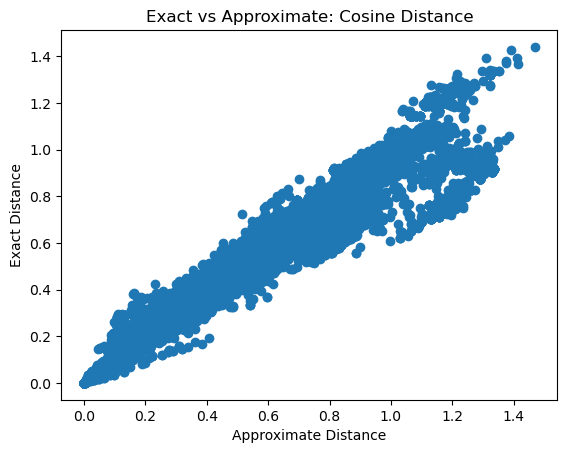

Real:
min	: 0.0
mean	: 0.4696730976647094
max	: 1.4401601400403519
var	: 0.06160257665737095

Approx:
min	: 0.0
mean	: 0.4932188821783209
max	: 1.4687965653147086
var	: 0.07405980336866902

p_val	: 1.114945821638794e-25
z_score	: -10.48127793698999


In [14]:
plot_distances(cosine_distance_vector, approx_cosine_distance_vector, "Cosine")
z_score, p_value, dof = ttest_ind(cosine_distance_vector, approx_cosine_distance_vector)
print("\np_val\t:", p_value)
print("z_score\t:", z_score)